# End-to-End Halal Product Intelligence Pipeline

> Optimised Colab-ready workflow for training halal logo detection, ingredient text classification, and unified inference with OCR + barcode support.

This notebook consolidates the full workflow into modular, fault-tolerant cells so it can be executed from top to bottom in Google Colab without manual patching. Each section has guard clauses to handle missing datasets or API credentials gracefully.

---



## 0. Runtime Setup

- ✅ Target platform: Google Colab (Python 3.10+, CUDA optional)
- 📦 Core dependencies: `tensorflow`, `torch`, `opencv-python`, `easyocr`, `beautifulsoup4`, `requests`, `scikit-learn`, `pyzbar`, `pandas`, `numpy`
- 💾 Storage: this notebook writes datasets/models to `/content/halal_pipeline`

Run the cell below once after opening the notebook. It installs all requirements and performs lightweight sanity checks.



In [1]:
%%capture
import sys
import subprocess

REQUIRED_PACKAGES = [
    "tensorflow>=2.16.0",
    "torch>=2.3.0",
    "torchvision>=0.18.0",
    "opencv-python>=4.9.0",
    "easyocr>=1.7.1",
    "beautifulsoup4",
    "requests",
    "scikit-learn",
    "pyzbar",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "tqdm",
    "joblib",
    "roboflow",
]

for pkg in REQUIRED_PACKAGES:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("All packages installed.")


In [2]:
!apt-get update
!apt-get install -y libzbar0

import os
import json
import time
import math
import base64
import random
import string
import zipfile
import logging
import re
import shutil
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

import torch
from torchvision import transforms

import cv2
import easyocr
from pyzbar import pyzbar

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load

from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm

from roboflow import Roboflow

logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(message)s")

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)



Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,123 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Pack

In [3]:
BASE_DIR = Path("/content/halal_pipeline")
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = BASE_DIR / "models"
OUTPUTS_DIR = BASE_DIR / "outputs"

for folder in [BASE_DIR, DATA_DIR, RAW_DIR, PROCESSED_DIR, MODELS_DIR, OUTPUTS_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

SEED = 1337
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("Working directory tree initialised at", BASE_DIR)



Working directory tree initialised at /content/halal_pipeline


## 1. Data Acquisition

We collect three complementary resources:

1. **E-code registry** for ingredient-level supervision (halal / haram / mushbooh).
2. **Halal logo images** to train a binary detector (`logo` vs `no_logo`).
3. **Optional local imagery** (ingredient panels / packaging) that you may mount manually for OCR benchmarking.

Each downloader uses polite scraping with retry/backoff and skips execution when files already exist.



In [4]:
def scrape_ecode_sources(output_csv: Path) -> pd.DataFrame:
    if output_csv.exists():
        logging.info("E-code CSV already exists: %s", output_csv)
        return pd.read_csv(output_csv)

    sources = [
        "https://www.ecodehalalcheck.com/",
        "https://international-halal.com/ecodes/",
        "https://ecode.figlab.io/quick_list.html",
    ]

    records: List[Dict[str, str]] = []

    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }

    def normalise_status(text: str) -> str:
        text = (text or "").strip().lower()
        if "haram" in text:
            return "Haram"
        if "mushbooh" in text or "doubt" in text:
            return "Mushbooh"
        if "halal" in text:
            return "Halal"
        return "Unknown"

    for url in sources:
        logging.info("Scraping %s", url)
        try:
            response = requests.get(url, headers=headers, timeout=20)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "html.parser")

            tables = soup.find_all("table")
            for table in tables:
                headers_row = [th.get_text(strip=True) for th in table.find_all("th")]
                if not headers_row:
                    continue

                rows = table.find_all("tr")
                for row in rows[1:]:
                    cells = [td.get_text(strip=True) for td in row.find_all("td")]
                    if len(cells) != len(headers_row):
                        continue
                    row_dict = dict(zip(headers_row, cells))
                    code = row_dict.get("E-Code") or row_dict.get("Code") or row_dict.get("Number")
                    name = row_dict.get("Name") or row_dict.get("Ingredient") or ""
                    status = row_dict.get("Halal Status") or row_dict.get("Status") or "Unknown"
                    description = row_dict.get("Description") or row_dict.get("Details") or ""
                    if code:
                        records.append(
                            {
                                "e_code_number": code.strip().upper().replace(" ", ""),
                                "name": name,
                                "halal_status": normalise_status(status),
                                "description": description,
                                "source": url,
                            }
                        )
        except Exception as exc:
            logging.warning("Failed to scrape %s: %s", url, exc)

    df = pd.DataFrame.from_records(records).drop_duplicates("e_code_number")
    if df.empty:
        raise RuntimeError("Failed to collect E-code data; check source availability")

    df.to_csv(output_csv, index=False)
    logging.info("Saved %d E-codes to %s", len(df), output_csv)
    return df

ECODE_CSV = RAW_DIR / "ecode_database.csv"
ecode_df = scrape_ecode_sources(ECODE_CSV)
ecodedf_preview = ecode_df.head()
print("Sample E-codes:\n", ecodedf_preview)



Sample E-codes:
   e_code_number                                 name halal_status description  \
0          E100                    Curcumin/Turmeric     Mushbooh       Color   
1          E101              Riboflavin (Vitamin B2)     Mushbooh       Color   
2          E102                           Tartrazine     Mushbooh       Color   
3          E104                                           Unknown               
4          E110  Sunset Yellow FCF / Orange Yellow S     Mushbooh       Color   

                                    source  
0  https://international-halal.com/ecodes/  
1  https://international-halal.com/ecodes/  
2  https://international-halal.com/ecodes/  
3  https://international-halal.com/ecodes/  
4  https://international-halal.com/ecodes/  


### 1.1 Optional: Download image datasets from Kaggle

Skip this cell if you already placed image folders under `RAW_DIR`. To enable Kaggle downloads in Colab, upload your `kaggle.json` API token to `/content` before executing the next cell.



In [6]:
from typing import Any, Dict, Optional

USE_REMOTE_DATA = True  # flip to False to rely on pre-mounted datasets only

ROBOFLOW_CONFIG = {
    "api_key": "feukKanicdiSX7SHcWDn",
    "workspace": "bugboisdd",
    "project": "halal-logo-dqkxm-ee1v8",
    "version": 1,
    "format": "multiclass",
    "target_dir": RAW_DIR / "roboflow_halal_logo",
}

KAGGLE_DATASETS = {
    "food_ingredients_halal_label": "irfanakbarihabibi/food-ingredients-dataset-with-halal-label",
}

ingredient_csv_paths: List[Path] = []
roboflow_logo_root: Optional[Path] = None


def download_kaggle_dataset(dataset_ref: str, target_dir: Path) -> bool:
    cmd = [
        "kaggle",
        "datasets",
        "download",
        "-d",
        dataset_ref,
        "-p",
        str(target_dir),
        "--force",
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        logging.warning("Kaggle download failed for %s: %s", dataset_ref, result.stderr.strip())
        return False
    for zip_path in target_dir.glob("*.zip"):
        try:
            with zipfile.ZipFile(zip_path, "r") as zip_ref:
                zip_ref.extractall(target_dir)
            zip_path.unlink()
        except Exception as exc:
            logging.warning("Failed to extract %s: %s", zip_path, exc)
            return False
    return True


def download_roboflow_dataset(config: Dict[str, Any]) -> Optional[Path]:
    try:
        logging.info(
            "Downloading Roboflow dataset %s/%s (v%s)",
            config["workspace"],
            config["project"],
            config["version"],
        )
        rf = Roboflow(api_key=config["api_key"])
        project = rf.workspace(config["workspace"]).project(config["project"])
        version = project.version(config["version"])
        dataset = version.download(config["format"])
    except Exception as exc:
        logging.warning("Roboflow download failed: %s", exc)
        return None

    source_root = Path(getattr(dataset, "location", ""))
    if not source_root.exists():
        logging.warning("Roboflow download reported %s but the path does not exist", source_root)
        return None

    target_dir = Path(config["target_dir"])
    if source_root.resolve() != target_dir.resolve():
        target_dir.mkdir(parents=True, exist_ok=True)
        shutil.copytree(source_root, target_dir, dirs_exist_ok=True)
        logging.info("Copied Roboflow dataset into %s", target_dir)
        return target_dir

    logging.info("Roboflow dataset ready at %s", source_root)
    return source_root


if USE_REMOTE_DATA:
    kaggle_token = Path("/content/kaggle.json")
    if kaggle_token.exists():
        os.environ["KAGGLE_CONFIG_DIR"] = "/content"
        for folder_name, dataset_ref in KAGGLE_DATASETS.items():
            target_dir = RAW_DIR / folder_name
            target_dir.mkdir(parents=True, exist_ok=True)
            logging.info("Downloading %s to %s", dataset_ref, target_dir)
            success = download_kaggle_dataset(dataset_ref, target_dir)
            if not success:
                logging.warning("Skipping dataset %s due to download issues.", dataset_ref)
    else:
        logging.info("kaggle.json not provided; skipping Kaggle dataset downloads.")

    roboflow_logo_root = download_roboflow_dataset(ROBOFLOW_CONFIG)
else:
    logging.info("Skipping remote downloads. Datasets must already be available under %s", RAW_DIR)
    default_logo_root = ROBOFLOW_CONFIG["target_dir"]
    if default_logo_root.exists():
        roboflow_logo_root = default_logo_root

ingredient_dataset_dir = RAW_DIR / "food_ingredients_halal_label"
if ingredient_dataset_dir.exists():
    ingredient_csv_paths = sorted(ingredient_dataset_dir.rglob("*.csv"))
else:
    ingredient_dataset_dir.mkdir(parents=True, exist_ok=True)
    ingredient_csv_paths = []

ROBOFLOW_LOGO_ROOT = roboflow_logo_root
INGREDIENT_CSV_PATHS = ingredient_csv_paths



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Halal-Logo-1 in multiclass:: 100%|██████████| 722/722 [00:00<00:00, 4787.42it/s]


In [7]:
def scan_image_directory(root: Path, label_map: Optional[Dict[str, str]] = None) -> pd.DataFrame:
    records = []
    if not root.exists():
        logging.warning("Image root %s does not exist", root)
        return pd.DataFrame(columns=["path", "label"])

    if label_map is None:
        label_map = {
            child.name: child.name
            for child in root.iterdir()
            if child.is_dir()
        }

    for class_dir, label in label_map.items():
        folder = root / class_dir
        if not folder.exists():
            logging.warning("Missing sub-directory %s for label %s", folder, label)
            continue
        for path in folder.rglob("*"):
            if path.suffix.lower() in {".png", ".jpg", ".jpeg", ".bmp", ".webp"}:
                records.append({"path": path, "label": label})
    return pd.DataFrame(records)


def load_roboflow_logo_dataframe(root: Optional[Path]) -> pd.DataFrame:
    if root is None:
        logging.warning("Roboflow logo dataset root is not available.")
        return pd.DataFrame(columns=["path", "label", "split"])
    if not root.exists():
        logging.warning("Roboflow logo dataset root %s does not exist", root)
        return pd.DataFrame(columns=["path", "label", "split"])

    frames: List[pd.DataFrame] = []
    for split in ["train", "valid", "test"]:
        split_dir = root / split
        if not split_dir.exists():
            continue
        split_df = scan_image_directory(split_dir)
        if split_df.empty:
            continue
        split_df["split"] = split
        frames.append(split_df)

    if frames:
        return pd.concat(frames, ignore_index=True)

    fallback_df = scan_image_directory(root)
    if fallback_df.empty:
        return pd.DataFrame(columns=["path", "label", "split"])
    fallback_df["split"] = "unspecified"
    return fallback_df


logo_df = load_roboflow_logo_dataframe(ROBOFLOW_LOGO_ROOT)
print("Roboflow halal logo dataset size:", len(logo_df))

PACKAGING_LABEL_MAP = {
    "ingredient": "ingredient_panel",
    "packaging": "packaging",
}
PACKAGING_ROOT = RAW_DIR / "product_packaging_images"
if PACKAGING_ROOT.exists():
    packaging_df = scan_image_directory(PACKAGING_ROOT, PACKAGING_LABEL_MAP)
else:
    logging.info("Packaging dataset directory %s not found; continuing without packaging data.", PACKAGING_ROOT)
    packaging_df = pd.DataFrame(columns=["path", "label"])
print("Packaging/ingredient dataset size:", len(packaging_df))



Roboflow halal logo dataset size: 714
Packaging/ingredient dataset size: 0


In [8]:
dataset_rows = [
    {"Dataset": "Roboflow Halal Logos", "Count": len(logo_df)},
    {"Dataset": "Ingredient CSV Files", "Count": len(INGREDIENT_CSV_PATHS)},
]

if not packaging_df.empty:
    dataset_rows.append({
        "Dataset": "Packaging/Ingredient (local upload)",
        "Count": len(packaging_df),
    })

display_df = pd.DataFrame(dataset_rows)

display(display_df)



,Dataset,Count
0,Roboflow Halal Logos,714
1,Ingredient CSV Files,1


## 2. Ingredient Text Classifier (Halal / Haram / Mushbooh)

We blend the E-code registry with the Kaggle `food-ingredients-dataset-with-halal-label` resource to create labelled ingredient lists, then train an end-to-end Keras model (`TextVectorization` + CNN) that we export as an `.h5` file for mobile deployment.



In [10]:
from typing import Any, Dict, Optional
import unicodedata
RULE_BASED_HARAM_KEYWORDS = {
    "alcohol",
    "ethanol",
    "rum",
    "beer",
    "wine",
    "bacon",
    "ham",
    "porcine",
    "pork",
    "lard",
    "gelatin",
    "gelatine",
    "carmine",
    "e120",
    "cochineal",
    "pepsin",
    "rennet",
    "lipase",
}

RULE_BASED_HALAL_KEYWORDS = {
    "halal certified",
    "halal-certified",
    "zabiha",
    "halal slaughtered",
}

def normalise_text(text: Optional[str]) -> str:
    if not text:
        return ""
    text = unicodedata.normalize("NFKD", text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s,.;:/%()\-&]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

ecode_status_map = {
    row.e_code_number.upper(): row.halal_status
    for row in ecode_df.itertuples()
    if isinstance(row.e_code_number, str)
}

ECODE_PATTERN = re.compile(r"E\d{1,4}[A-Z]?")

ingredient_texts: List[str] = []
ingredient_labels: List[str] = []
ingredient_sources: List[str] = []


def derive_label_from_text(raw_text: Optional[str]) -> Optional[Tuple[str, str]]:
    normalized = normalise_text(raw_text)
    if not normalized:
        return None
    upper_text = normalized.upper()
    codes = {code for code in ECODE_PATTERN.findall(upper_text)}
    statuses = [ecode_status_map.get(code) for code in codes if ecode_status_map.get(code)]
    if any(keyword in normalized for keyword in RULE_BASED_HARAM_KEYWORDS):
        label = "Haram"
    elif statuses and any(status == "Haram" for status in statuses):
        label = "Haram"
    elif statuses and all(status == "Halal" for status in statuses):
        label = "Halal"
    elif statuses and any(status == "Mushbooh" for status in statuses):
        label = "Mushbooh"
    elif any(keyword in normalized for keyword in RULE_BASED_HALAL_KEYWORDS):
        label = "Halal"
    else:
        label = None
    if label is None:
        return None
    return normalized, label

TEXT_COLUMN_CANDIDATES = {
    "ingredient",
    "ingredients",
    "ingredients_text",
    "ingredient_text",
    "raw_ingredients",
    "text",
    "description",
}

LABEL_COLUMN_CANDIDATES = {
    "halal_label",
    "halal_status",
    "label",
    "status",
    "classification",
    "category",
}

def normalise_kaggle_label(value: Any) -> Optional[str]:
    if value is None or (isinstance(value, float) and math.isnan(value)):
        return None
    if pd.isna(value):
        return None
    if isinstance(value, (int, float)):
        if value == 1:
            return "Halal"
        if value == 0:
            return "Haram"
    text_value = str(value).strip().lower()
    if not text_value:
        return None
    canonical = re.sub(r"[^a-z0-9]+", " ", text_value).strip()
    mapping = {
        "halal": "Halal",
        "h": "Halal",
        "haram": "Haram",
        "non halal": "Haram",
        "non halal product": "Haram",
        "non-halal": "Haram",
        "mushbooh": "Mushbooh",
        "doubtful": "Mushbooh",
    }
    return mapping.get(canonical)


def extract_text_label_pairs_from_df(df: pd.DataFrame) -> List[Tuple[str, str]]:
    available_text_cols = [col for col in df.columns if col.lower() in TEXT_COLUMN_CANDIDATES]
    available_label_cols = [col for col in df.columns if col.lower() in LABEL_COLUMN_CANDIDATES]
    pairs: List[Tuple[str, str]] = []

    if available_text_cols and available_label_cols:
        text_col = available_text_cols[0]
        label_col = available_label_cols[0]
        for raw_text, raw_label in df[[text_col, label_col]].dropna().values:
            normalized_text = normalise_text(raw_text)
            normalized_label = normalise_kaggle_label(raw_label)
            if normalized_text and normalized_label:
                pairs.append((normalized_text, normalized_label))

    if not pairs and available_text_cols:
        logging.info("Falling back to heuristic labelling for Kaggle ingredient dataset.")
        for text_col in available_text_cols:
            for raw_text in df[text_col].dropna().astype(str).tolist():
                derived = derive_label_from_text(raw_text)
                if derived:
                    pairs.append(derived)
    return pairs


if INGREDIENT_CSV_PATHS:
    for csv_path in INGREDIENT_CSV_PATHS:
        try:
            df = pd.read_csv(csv_path)
        except Exception as exc:
            logging.warning("Failed to load %s: %s", csv_path, exc)
            continue
        pairs = extract_text_label_pairs_from_df(df)
        if not pairs:
            logging.warning("No labelled records extracted from %s", csv_path)
            continue
        for normalized, label in pairs:
            ingredient_texts.append(normalized)
            ingredient_labels.append(label)
            ingredient_sources.append(csv_path.stem)
else:
    logging.warning("No ingredient CSV files available. Only E-code data will be used for training.")

# Augment with E-code descriptive texts to balance classes
for row in ecode_df.itertuples():
    if row.halal_status == "Unknown":
        continue
    combined_text = f"{row.e_code_number or ''} {row.name or ''} {row.description or ''}"
    normalized, label = normalise_text(combined_text), row.halal_status
    if normalized:
        ingredient_texts.append(normalized)
        ingredient_labels.append(label)
        ingredient_sources.append("ecode")

ingredient_training_df = pd.DataFrame({
    "text": ingredient_texts,
    "label": ingredient_labels,
    "source": ingredient_sources,
}).drop_duplicates("text").reset_index(drop=True)

print("Ingredient training samples:", len(ingredient_training_df))
print(ingredient_training_df["label"].value_counts())



Ingredient training samples: 39715
label
Halal       21714
Haram       17961
Mushbooh       40
Name: count, dtype: int64


In [11]:
MAX_TOKENS = 20000
SEQUENCE_LENGTH = 200
TEXT_BATCH_SIZE = 64

texts = ingredient_training_df["text"].to_numpy()
labels = ingredient_training_df["label"].to_numpy()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    texts,
    encoded_labels,
    test_size=0.2,
    random_state=SEED,
    stratify=encoded_labels,
)

vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=SEQUENCE_LENGTH,
    standardize=None,
)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(TEXT_BATCH_SIZE))

num_classes = len(label_encoder.classes_)

def make_text_dataset(text_array, label_array, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((text_array, label_array))
    if shuffle:
        ds = ds.shuffle(len(text_array), seed=SEED)
    return ds.batch(TEXT_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_text_dataset(X_train, y_train, shuffle=True)
val_ds = make_text_dataset(X_test, y_test, shuffle=False)

ingredient_model = keras.Sequential([
    vectorizer,
    layers.Embedding(MAX_TOKENS + 1, 128, mask_zero=True),
    layers.Conv1D(128, 5, activation="relu"),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax"),
])

ingredient_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

ingredient_callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-5),
]

history = ingredient_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=ingredient_callbacks,
    verbose=1,
)

val_probs = ingredient_model.predict(val_ds, verbose=0)
y_pred = val_probs.argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Epoch 1/12


Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.


497/497 ━━━━━━━━━━━━━━━━━━━━ 110s 218ms/step - accuracy: 0.8581 - loss: 0.3141 - val_accuracy: 0.9929 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 2/12
497/497 ━━━━━━━━━━━━━━━━━━━━ 138s 210ms/step - accuracy: 0.9946 - loss: 0.0267 - val_accuracy: 0.9933 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 3/12
497/497 ━━━━━━━━━━━━━━━━━━━━ 105s 212ms/step - accuracy: 0.9970 - loss: 0.0140 - val_accuracy: 0.9943 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 4/12
497/497 ━━━━━━━━━━━━━━━━━━━━ 103s 207ms/step - accuracy: 0.9984 - loss: 0.0069 - val_accuracy: 0.9938 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 5/12
497/497 ━━━━━━━━━━━━━━━━━━━━ 142s 207ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9940 - val_loss: 0.0335 - learning_rate: 2.0000e-04
              precision    recall  f1-score   support

       Halal       0.99      1.00      0.99      4343
       Haram       0.99      0.99      0.99      3592
    Mushbooh       0.00      0.00      0.00         8

    accur

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


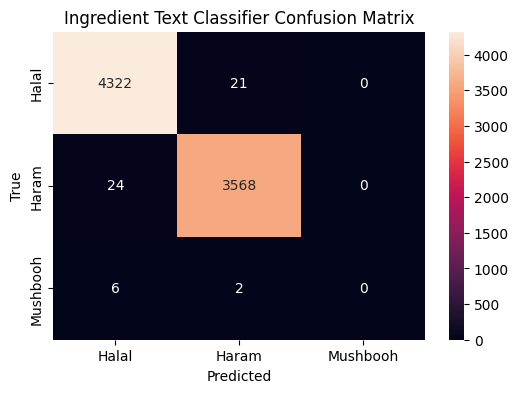

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Ingredient Text Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [13]:
INGREDIENT_MODEL_PATH = MODELS_DIR / "ingredient_text_classifier.h5"
INGREDIENT_LABELS_PATH = MODELS_DIR / "ingredient_text_labels.json"

ingredient_model.save(INGREDIENT_MODEL_PATH)
with open(INGREDIENT_LABELS_PATH, "w", encoding="utf-8") as fp:
    json.dump(label_encoder.classes_.tolist(), fp)

print("Saved ingredient classifier to", INGREDIENT_MODEL_PATH)
print("Saved ingredient label map to", INGREDIENT_LABELS_PATH)



Saved ingredient classifier to /content/halal_pipeline/models/ingredient_text_classifier.h5
Saved ingredient label map to /content/halal_pipeline/models/ingredient_text_labels.json


### 2.1 Barcode Status Classifier (Halal / Haram)

We reuse the scraped E-code registry as a proxy for additive barcodes. Each code’s numeric signature becomes a feature vector, and we train a multinomial logistic regression model that predicts `Halal`, `Haram`, or `Mushbooh`. The resulting pipeline can score barcodes directly and is saved for backend integration.



In [14]:
barcode_df = ecode_df.copy()
barcode_df["barcode"] = barcode_df["e_code_number"].str.replace("E", "", regex=False)
barcode_df = barcode_df[barcode_df["barcode"].str.isdigit()]
barcode_df = barcode_df[barcode_df["halal_status"] != "Unknown"].reset_index(drop=True)

if not barcode_df.empty:
    barcode_texts = barcode_df["barcode"].astype(str).to_numpy()
    barcode_labels = barcode_df["halal_status"].to_numpy()

    barcode_label_encoder = LabelEncoder()
    encoded_barcode_labels = barcode_label_encoder.fit_transform(barcode_labels)

    Xb_train, Xb_test, yb_train, yb_test = train_test_split(
        barcode_texts,
        encoded_barcode_labels,
        test_size=0.2,
        random_state=SEED,
        stratify=encoded_barcode_labels,
    )

    BARCODE_MAX_LENGTH = max(len(code) for code in barcode_texts)

    barcode_vectorizer = TextVectorization(
        max_tokens=16,
        standardize=None,
        split="character",
        output_mode="int",
        output_sequence_length=BARCODE_MAX_LENGTH,
    )
    barcode_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(Xb_train))

    BARCODE_BATCH = 32

    def make_barcode_ds(text_array, label_array, shuffle=True):
        ds = tf.data.Dataset.from_tensor_slices((text_array, label_array))
        if shuffle:
            ds = ds.shuffle(len(text_array), seed=SEED)
        return ds.batch(BARCODE_BATCH).prefetch(tf.data.AUTOTUNE)

    barcode_train_ds = make_barcode_ds(Xb_train, yb_train, shuffle=True)
    barcode_val_ds = make_barcode_ds(Xb_test, yb_test, shuffle=False)

    barcode_num_classes = len(barcode_label_encoder.classes_)

    barcode_model = keras.Sequential([
        barcode_vectorizer,
        layers.Embedding(barcode_vectorizer.vocabulary_size(), 32, mask_zero=True),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dense(32, activation="relu"),
        layers.Dense(barcode_num_classes, activation="softmax"),
    ])

    barcode_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    barcode_callbacks = [
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ]

    barcode_model.fit(
        barcode_train_ds,
        validation_data=barcode_val_ds,
        epochs=20,
        callbacks=barcode_callbacks,
        verbose=1,
    )

    barcode_probs = barcode_model.predict(barcode_val_ds, verbose=0)
    barcode_predictions = barcode_probs.argmax(axis=1)
    print(classification_report(yb_test, barcode_predictions, target_names=barcode_label_encoder.classes_))

    BARCODE_MODEL_PATH = MODELS_DIR / "barcode_status_classifier.h5"
    BARCODE_LABELS_PATH = MODELS_DIR / "barcode_status_labels.json"

    barcode_model.save(BARCODE_MODEL_PATH)
    with open(BARCODE_LABELS_PATH, "w", encoding="utf-8") as fp:
        json.dump(barcode_label_encoder.classes_.tolist(), fp)

    print("Saved barcode classifier to", BARCODE_MODEL_PATH)
    print("Saved barcode label map to", BARCODE_LABELS_PATH)
else:
    print("No numeric E-code data available to train barcode classifier.")



Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.4839 - loss: 0.6834 - val_accuracy: 0.7308 - val_loss: 0.6246
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7666 - loss: 0.6008 - val_accuracy: 0.7308 - val_loss: 0.5498
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7822 - loss: 0.5120 - val_accuracy: 0.7308 - val_loss: 0.5609
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7572 - loss: 0.5118 - val_accuracy: 0.7308 - val_loss: 0.5345
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7781 - loss: 0.4746 - val_accuracy: 0.7308 - val_loss: 0.5242
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7760 - loss: 0.4765 - val_accuracy: 0.7308 - val_loss: 0.5150
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7654 - loss: 0.4655 - val_accuracy: 0.7308 - val_loss: 0.4882
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7539 - loss: 0.4576 - val_accuracy: 0.8077 - val_loss: 0.4630

              precision    recall  f1-score   support

       Halal       0.89      0.84      0.86        19
    Mushbooh       0.62      0.71      0.67         7

    accuracy                           0.81        26
   macro avg       0.76      0.78      0.77        26
weighted avg       0.82      0.81      0.81        26

Saved barcode classifier to /content/halal_pipeline/models/barcode_status_classifier.h5
Saved barcode label map to /content/halal_pipeline/models/barcode_status_labels.json


## 3. Halal Logo Detector (Transfer Learning)

We fine-tune a MobileNetV2 backbone for binary classification (`logo` vs `no_logo`). Training automatically skips if the dataset is missing.



In [16]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


def build_logo_datasets(df: pd.DataFrame):
    if df.empty:
        logging.warning("Logo dataset empty; skipping training")
        return None

    temp_manifest = PROCESSED_DIR / "logo_manifest.csv"
    df.to_csv(temp_manifest, index=False)

    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image.set_shape([None, None, 3])  # Add this line to set the shape
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, IMG_SIZE)
        return image, label

    class_names = sorted(df["label"].unique())
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df["label"])

    train_df, val_df, train_labels, val_labels = train_test_split(
        df["path"].astype(str),
        encoded_labels,
        test_size=0.2,
        stratify=encoded_labels,
        random_state=SEED,
    )

    def make_dataset(paths, labels):
        ds = tf.data.Dataset.from_tensor_slices((paths.tolist(), labels.tolist()))
        ds = ds.shuffle(len(paths), seed=SEED)
        ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    train_ds = make_dataset(train_df, train_labels)
    val_ds = make_dataset(val_df, val_labels)

    return train_ds, val_ds, label_encoder

logo_data = build_logo_datasets(logo_df)

In [18]:
LOGO_MODEL_PATH = MODELS_DIR / "halal_logo_detector.keras"
LOGO_MODEL_H5_PATH = MODELS_DIR / "halal_logo_detector.h5"

if LOGO_MODEL_PATH.exists() and LOGO_MODEL_H5_PATH.exists():
    print("Logo detector artefacts available:", LOGO_MODEL_PATH.name, LOGO_MODEL_H5_PATH.name)
else:
    print("Logo detector checkpoint not found; training will start now.")




Logo detector checkpoint not found; training will start now.


In [19]:
LOGO_MODEL_PATH = MODELS_DIR / "halal_logo_detector.keras"
LOGO_MODEL_H5_PATH = MODELS_DIR / "halal_logo_detector.h5"

if logo_data is None:
    logo_model = None
else:
    train_ds, val_ds, logo_label_encoder = logo_data

    base_model = keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    logo_model = keras.Model(inputs, outputs)
    logo_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    callbacks = [
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-5),
    ]

    history = logo_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=callbacks,
        verbose=1,
    )

    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(OUTPUTS_DIR / "logo_training_history.csv", index=False)
    dump(logo_label_encoder, MODELS_DIR / "logo_label_encoder.joblib")

    logo_model.save(LOGO_MODEL_PATH)
    logo_model.save(LOGO_MODEL_H5_PATH)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8691 - loss: 0.0749 - val_accuracy: 0.8741 - val_loss: -0.2516 - learning_rate: 0.0010
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8686 - loss: -0.2547 - val_accuracy: 0.8741 - val_loss: -0.3872 - learning_rate: 0.0010
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8741 - loss: -0.3944 - val_accuracy: 0.8741 - val_loss: -0.4944 - learning_rate: 0.0010
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8870 - loss: -0.3463 - val_accuracy: 0.8741 - val_loss: -0.5925 - learning_rate: 0.0010
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8735 - loss: -0.6757 - val_accuracy: 0.8741 - val_loss: -0.7120 - learning_rate: 0.0010
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8664 - loss: -0.2592 - val_accuracy: 0.8741 - val_loss: -0.7942 - learning_rate: 0.0010
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 35

In [ ]:
if LOGO_MODEL_PATH.exists():
    logo_model = keras.models.load_model(LOGO_MODEL_PATH)
    print("Loaded logo model from", LOGO_MODEL_PATH)
else:
    logo_model = None



## 4. Unified Inference Helpers

We expose reusable functions to:

- Run OCR (EasyOCR) and clean ingredient text.
- Classify ingredients via the trained text model.
- Detect halal logos via the CNN.
- Decode barcodes via `pyzbar`.
- Combine rule-based logic with learned predictions to produce a final verdict.



In [ ]:
reader = easyocr.Reader(["en"], gpu=torch.cuda.is_available())

ingredient_classifier = None
ingredient_label_classes: List[str] = []
if INGREDIENT_MODEL_PATH.exists():
    ingredient_classifier = keras.models.load_model(INGREDIENT_MODEL_PATH)
    with open(INGREDIENT_LABELS_PATH, "r", encoding="utf-8") as fp:
        ingredient_label_classes = json.load(fp)

barcode_classifier = None
barcode_label_classes: List[str] = []
BARCODE_MODEL_PATH = MODELS_DIR / "barcode_status_classifier.h5"
BARCODE_LABELS_PATH = MODELS_DIR / "barcode_status_labels.json"
if BARCODE_MODEL_PATH.exists() and BARCODE_LABELS_PATH.exists():
    barcode_classifier = keras.models.load_model(BARCODE_MODEL_PATH)
    with open(BARCODE_LABELS_PATH, "r", encoding="utf-8") as fp:
        barcode_label_classes = json.load(fp)


def classify_text(text: str) -> Dict[str, float]:
    if ingredient_classifier is None or not ingredient_label_classes:
        return {label: 0.0 for label in ["Halal", "Haram", "Mushbooh"]}
    normalized = normalise_text(text)
    if not normalized:
        return {label: 0.0 for label in ingredient_label_classes}
    probs = ingredient_classifier.predict([normalized], verbose=0)[0]
    return {
        ingredient_label_classes[idx]: float(score)
        for idx, score in enumerate(probs)
    }


def classify_barcode_value(barcode: str) -> Optional[Tuple[str, float, Dict[str, float]]]:
    if barcode_classifier is None or not barcode_label_classes:
        return None
    probs = barcode_classifier.predict([barcode], verbose=0)[0]
    best_idx = int(np.argmax(probs))
    distribution = {
        barcode_label_classes[idx]: float(score)
        for idx, score in enumerate(probs)
    }
    return barcode_label_classes[best_idx], float(probs[best_idx]), distribution


def rule_based_status(text: str) -> Optional[str]:
    normalized = normalise_text(text)
    for keyword in RULE_BASED_HARAM_KEYWORDS:
        if keyword in normalized:
            return "Haram"
    for keyword in RULE_BASED_HALAL_KEYWORDS:
        if keyword in normalized:
            return "Halal"
    return None



### Downloadable Artefacts

- `barcode_status_classifier.h5`
- `barcode_status_labels.json`
- `ingredient_text_classifier.h5`
- `ingredient_text_labels.json`
- `halal_logo_detector.keras`
- `halal_logo_detector.h5`
- `logo_label_encoder.joblib`

Use `from google.colab import files; files.download(path)` to pull each model to your machine.



In [ ]:
def decode_barcodes(image_path: Path) -> List[str]:
    image = cv2.imread(str(image_path))
    if image is None:
        return []
    barcodes = pyzbar.decode(image)
    return [barcode.data.decode("utf-8") for barcode in barcodes]


def detect_logo(image_path: Path) -> Tuple[bool, float]:
    if logo_model is None:
        return False, 0.0
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    preds = logo_model.predict(tf.expand_dims(image, axis=0), verbose=0)[0][0]
    return preds >= 0.5, float(preds)


def run_ocr(image_path: Path) -> str:
    result = reader.readtext(str(image_path), detail=0, paragraph=True)
    text = " \n".join(result)
    return normalise_text(text)


def classify_product_image(
    image_path: Path,
    product_name: str = "Unknown Product",
    barcode_hint: Optional[str] = None,
) -> Dict[str, Any]:
    if not image_path.exists():
        raise FileNotFoundError(image_path)

    barcode_values = decode_barcodes(image_path)
    if barcode_hint:
        barcode_values.append(barcode_hint)
    barcode_values = list(dict.fromkeys(barcode_values))  # deduplicate preserving order

    ocr_text = run_ocr(image_path)
    text_probs = classify_text(ocr_text)
    rule_status = rule_based_status(ocr_text)
    logo_flag, logo_conf = detect_logo(image_path)

    barcode_assessments = []
    for code in barcode_values:
        barcode_result = classify_barcode_value(code)
        if barcode_result:
            status, conf, distribution = barcode_result
            barcode_assessments.append({
                "barcode": code,
                "status": status,
                "confidence": conf,
                "distribution": distribution,
            })

    ecode_matches = sorted({match for match in ECODE_PATTERN.findall(ocr_text.upper())})
    ecode_assessments = [
        {
            "code": code,
            "status": ecode_status_map.get(code, "Unknown"),
        }
        for code in ecode_matches
    ]

    ingredient_status = max(text_probs, key=text_probs.get) if text_probs else "Unknown"
    ingredient_confidence = float(text_probs.get(ingredient_status, 0.0))

    weight_map = {"Halal": 0.0, "Haram": 0.0, "Mushbooh": 0.0}

    for assessment in barcode_assessments:
        status = assessment["status"]
        weight_map[status] = weight_map.get(status, 0.0) + assessment["confidence"]

    if rule_status:
        weight_map[rule_status] = weight_map.get(rule_status, 0.0) + 1.0

    weight_map[ingredient_status] = weight_map.get(ingredient_status, 0.0) + ingredient_confidence

    for assessment in ecode_assessments:
        status = assessment["status"]
        weight_map[status] = weight_map.get(status, 0.0) + 0.6

    if logo_flag:
        weight_map["Halal"] = weight_map.get("Halal", 0.0) + logo_conf

    verdict_priority = ["Haram", "Halal", "Mushbooh"]

    def priority_score(status: str) -> float:
        if status in verdict_priority:
            return -verdict_priority.index(status)
        return -float(len(verdict_priority))

    if any(weight_map.values()):
        top_status = max(weight_map.items(), key=lambda item: (item[1], priority_score(item[0])))[0]
    else:
        top_status = "Unknown"

    ingredient_analysis = {
        "predicted_status": ingredient_status,
        "confidence": ingredient_confidence,
        "probabilities": text_probs,
        "rule_based": rule_status,
    }

    logo_analysis = {
        "detected": logo_flag,
        "confidence": logo_conf,
    }

    ecode_analysis_str = ", ".join(
        f"{entry['code']} ({entry['status']})" for entry in ecode_assessments
    ) if ecode_assessments else "No E-codes detected"

    return {
        "Product Name": product_name,
        "Barcode": barcode_values[0] if barcode_values else None,
        "E-Code Analysis": {
            "summary": ecode_analysis_str,
            "details": ecode_assessments,
        },
        "Ingredient Analysis": ingredient_analysis,
        "Logo Detection": logo_analysis,
        "Barcode Analysis": barcode_assessments,
        "Final Verdict": top_status,
        "Evidence": {
            "weighting": weight_map,
            "ocr_text": ocr_text,
        },
    }



In [ ]:
# Demo: update `sample_image_path` to point at any product photo (packaging / ingredient panel)
sample_image_path = RAW_DIR / "demos" / "sample_product.jpg"

if sample_image_path.exists():
    result = classify_product_image(sample_image_path)
    print(json.dumps(result, indent=2))
else:
    logging.warning("Sample image not found at %s. Add a demo image to run the inference showcase.", sample_image_path)



## 5. Next Steps & Export

- 📁 Trained artefacts live under `MODELS_DIR` and can be downloaded from Colab with `files.download(...)`.
- 🔁 To retrain with new data, refresh the raw folders and rerun Sections 2–3.
- 🚀 Integrate with your FastAPI backend by loading `ingredient_text_classifier.joblib` and `halal_logo_detector.keras`, then reusing the helper logic above (OCR, barcode, rules).

Happy shipping! 🎉

